## About
This program generates a stock screener that can filter stocks based on user preferences. It requires the yahoo_fin module and csv file from the Nasdaq stock screener for obtaining stocks data. It also requires the ipyparallel module for downloading the data in parallel.
<br> Enter the following code in terminal before running this program:
<br> $ ipcluster start -n N
<br> , where N is the number of engines.

## Import modules

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import pandas_ta as ta

## Set the ipyparallel

In [2]:
import ipyparallel as ipp

In [3]:
c = ipp.Client()
dv = c[:]

In [4]:
num_engines = len(c.ids)
num_engines

14

In [5]:
# remote
%px import pandas as pd
%px import yfinance as yf
%px import pandas_ta as ta
%px import numpy as np

## Set the ticker symbols

#### Fetch data from Nasdaq stock screener <a href='https://www.nasdaq.com/market-activity/stocks/screener'>(link)</a>

In [6]:
stocks = pd.read_csv('data/nasdaq_screener_1626347395770.csv', index_col=0)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7855 entries, A to ZYXI
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        7855 non-null   object 
 1   Last Sale   7855 non-null   object 
 2   Net Change  7855 non-null   float64
 3   % Change    7853 non-null   object 
 4   Market Cap  7238 non-null   float64
 5   Country     7120 non-null   object 
 6   IPO Year    4584 non-null   float64
 7   Volume      7855 non-null   int64  
 8   Sector      6273 non-null   object 
 9   Industry    6272 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 675.0+ KB


#### Optional: Remove small market cap stocks

In [7]:
market_cap_lim = 5e9
stocks = stocks[stocks['Market Cap'] > market_cap_lim]
len(stocks)

1349

In [8]:
tickers = list(stocks.index)
len(tickers)

1349

#### Add additional tickers

In [9]:
add_list = ['ARKK', 'ARKG', 'ARKF', 'ARKW', 'ARKQ', '^GSPC', '^JKSE', '^IXIC', 'ETH-USD', 'BTC-USD', 'TQQQ', 'QQQ']
tickers.extend(add_list)

## Set the start and end dates

In [10]:
start_date = datetime.now() - relativedelta(months=12)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

## Collect the company data via Yahoo Finance

#### Set the list of attributes

In [11]:
attr = ['shortName','sector','industry','longBusinessSummary','marketCap','operatingMargins',
        'ebitdaMargins','profitMargins','grossMargins','revenueGrowth','recommendationKey',
        'numberOfAnalystOpinions','currentPrice','targetLowPrice','targetMedianPrice','targetMeanPrice',
        'targetHighPrice','beta','trailingPE','forwardPE','dividendYield']

#### Split the ticker symbols into several groups based on the number of engines

In [12]:
ticker_group = [x.tolist() for x in np.array_split(tickers, num_engines)]

In [13]:
for group in ticker_group:
    print(len(group))

98
98
98
97
97
97
97
97
97
97
97
97
97
97


#### Download the company data

In [14]:
def download_asset_info(tickers, attributes):
    df = pd.DataFrame()
    for t in tickers:
        print(t)
        comp_info = yf.Ticker(t).info
        if comp_info is not None:
            for a in attributes:
                df.loc[t,a] = comp_info.get(a)
    return df

In [15]:
df_temp = dv.map(download_asset_info, ticker_group, [attr]*num_engines)

In [16]:
# See queue status
dv.queue_status()

{'unassigned': 0,
 0: {'queue': 1, 'completed': 4, 'tasks': 0},
 1: {'queue': 1, 'completed': 4, 'tasks': 0},
 2: {'queue': 1, 'completed': 4, 'tasks': 0},
 3: {'queue': 1, 'completed': 4, 'tasks': 0},
 4: {'queue': 1, 'completed': 4, 'tasks': 0},
 5: {'queue': 1, 'completed': 4, 'tasks': 0},
 6: {'queue': 1, 'completed': 4, 'tasks': 0},
 7: {'queue': 1, 'completed': 4, 'tasks': 0},
 8: {'queue': 1, 'completed': 4, 'tasks': 0},
 9: {'queue': 1, 'completed': 4, 'tasks': 0},
 10: {'queue': 1, 'completed': 4, 'tasks': 0},
 11: {'queue': 1, 'completed': 4, 'tasks': 0},
 12: {'queue': 1, 'completed': 4, 'tasks': 0},
 13: {'queue': 1, 'completed': 4, 'tasks': 0}}

In [17]:
# Combine the results into one dataframe
df = pd.concat(df_temp, axis=0)

#### Temporarily save the data

In [18]:
df.to_csv('data/screener_part1.csv')

#### Download stock historical data

In [19]:
def download_historical_data(tickers, start_date, end_date, attributes='Close'):
    hist = yf.download(tickers, start=start_date, end=end_date)[attributes]
    return hist

In [20]:
hist_temp = dv.map(download_historical_data, ticker_group, 
                   [start_date]*num_engines, [end_date]*num_engines)

In [21]:
# See queue status
dv.queue_status()

{'unassigned': 0,
 0: {'queue': 1, 'completed': 5, 'tasks': 0},
 1: {'queue': 1, 'completed': 5, 'tasks': 0},
 2: {'queue': 1, 'completed': 5, 'tasks': 0},
 3: {'queue': 1, 'completed': 5, 'tasks': 0},
 4: {'queue': 1, 'completed': 5, 'tasks': 0},
 5: {'queue': 1, 'completed': 5, 'tasks': 0},
 6: {'queue': 1, 'completed': 5, 'tasks': 0},
 7: {'queue': 1, 'completed': 5, 'tasks': 0},
 8: {'queue': 1, 'completed': 5, 'tasks': 0},
 9: {'queue': 1, 'completed': 5, 'tasks': 0},
 10: {'queue': 1, 'completed': 5, 'tasks': 0},
 11: {'queue': 1, 'completed': 5, 'tasks': 0},
 12: {'queue': 1, 'completed': 5, 'tasks': 0},
 13: {'queue': 1, 'completed': 5, 'tasks': 0}}

In [22]:
# Combine the results into one dataframe
hist = pd.concat(hist_temp, axis=1)

#### Temporarily save the data

In [23]:
hist.to_csv('data/historical_data.csv')

## Calculate other important attributes

#### Download market historical data

In [24]:
mkt_ticker = '^GSPC'
mkt_data = yf.download(mkt_ticker, start=start_date, end=end_date)['Close']
mkt_log_return = ta.log_return(mkt_data)

[*********************100%***********************]  1 of 1 completed


#### Calculate the stock attributes

In [25]:
def calc_stock_attributes(tickers, hist, mkt_log_return):
    df = pd.DataFrame(index=tickers)
    trading_days = 252
    for t in tickers:
        print(t)
        close = hist[t].dropna()
        log_return = ta.log_return(close)
        df.loc[t,'volatility'] = np.sqrt(log_return.var() * trading_days)
        df.loc[t,'annualReturn'] = log_return.mean()*trading_days
        df.loc[t,'sharpeRatio'] = ta.sharpe_ratio(close, log=True)
        df.loc[t,'RSI_20'] = ta.rsi(close, length=20)[-1]
        df.loc[t,'RSI_14'] = ta.rsi(close, length=14)[-1]
        df.loc[t,'marketCorrelation'] = \
            pd.concat([log_return, mkt_log_return],
                      axis=1).dropna().corr().iloc[0,1]
    return df

In [26]:
df_temp = dv.map(calc_stock_attributes, ticker_group, 
                 [hist]*num_engines, [mkt_log_return]*num_engines)

In [27]:
# See queue status
dv.queue_status()

{'unassigned': 0,
 0: {'queue': 1, 'completed': 6, 'tasks': 0},
 1: {'queue': 0, 'completed': 6, 'tasks': 0},
 2: {'queue': 0, 'completed': 6, 'tasks': 0},
 3: {'queue': 0, 'completed': 6, 'tasks': 0},
 4: {'queue': 0, 'completed': 6, 'tasks': 0},
 5: {'queue': 0, 'completed': 6, 'tasks': 0},
 6: {'queue': 0, 'completed': 6, 'tasks': 0},
 7: {'queue': 0, 'completed': 6, 'tasks': 0},
 8: {'queue': 0, 'completed': 6, 'tasks': 0},
 9: {'queue': 0, 'completed': 6, 'tasks': 0},
 10: {'queue': 0, 'completed': 6, 'tasks': 0},
 11: {'queue': 0, 'completed': 6, 'tasks': 0},
 12: {'queue': 0, 'completed': 6, 'tasks': 0},
 13: {'queue': 0, 'completed': 6, 'tasks': 0}}

In [28]:
# Combine the results into one dataframe
df2 = pd.concat(df_temp, axis=0)
df = pd.concat([df, df2], axis=1)

In [29]:
# Calculate percent discount based on analysts price targets
df['percentDiscount'] = np.round(100*(df['targetMedianPrice'] - df['currentPrice'])/
                                      df['currentPrice'],2)

## Determine the buying and selling signals

#### Buying signals using RSI strategy

In [30]:
%px
def fetch_signal_rsi(close, min_rsi =30, length_rsi=10, length_sma=200):
    # Calculate RSI and the standard moving average
    df = pd.DataFrame()
    df['RSI'] = ta.rsi(close, length=length_rsi)
    df['SMA'] = ta.sma(close, length=length_sma)
    # Replace None with NaN
    df = df.fillna(value=np.nan)

    # Get the buying signal
    df['Buy'] = np.where((close > df['SMA']) & 
                            (df['RSI'] < min_rsi), True, False)
    return df['Buy']

#### Buying and selling signals using Bollinger Band strategy

In [31]:
%px
def fetch_signal_bband(close, length=20):    
    # Calculate the Bollinger Bands
    df = ta.bbands(close, length=length)
    # Buy tomorrow if the value is lower than the low band
    df['Buy'] = np.where(close < df.iloc[:,0], True, False)
    # Sell tomorrow if the value is higher than the upper band
    df['Sell'] = np.where(close > df.iloc[:,2], True, False)
    return df[['Buy', 'Sell']]

#### Fetch the signals

In [34]:
@ipp.require(fetch_signal_bband, fetch_signal_rsi)
def fetch_buying_selling_signals(tickers, hist):
    df = pd.DataFrame(index=tickers)
    for t in tickers:
        # BBAND strategy
        result = fetch_signal_bband(hist[t].dropna())
        df.loc[t, 'buyBBAND'] = result.iloc[-1]['Buy']
        df.loc[t, 'sellBBAND'] = result.iloc[-1]['Sell']
        # RSI strategy
        result = fetch_signal_rsi(hist[t].dropna())
        df.loc[t, 'buyRSI'] = result.iloc[-1]    
    return df

In [35]:
df_temp = dv.map(fetch_buying_selling_signals, ticker_group, 
                 [hist]*num_engines)

In [36]:
# See queue status
dv.queue_status()

{'unassigned': 0,
 0: {'queue': 1, 'completed': 4, 'tasks': 0},
 1: {'queue': 1, 'completed': 4, 'tasks': 0},
 2: {'queue': 1, 'completed': 4, 'tasks': 0},
 3: {'queue': 1, 'completed': 4, 'tasks': 0},
 4: {'queue': 1, 'completed': 4, 'tasks': 0},
 5: {'queue': 1, 'completed': 4, 'tasks': 0},
 6: {'queue': 0, 'completed': 4, 'tasks': 0},
 7: {'queue': 0, 'completed': 4, 'tasks': 0},
 8: {'queue': 0, 'completed': 4, 'tasks': 0},
 9: {'queue': 0, 'completed': 4, 'tasks': 0},
 10: {'queue': 0, 'completed': 4, 'tasks': 0},
 11: {'queue': 0, 'completed': 4, 'tasks': 0},
 12: {'queue': 0, 'completed': 4, 'tasks': 0},
 13: {'queue': 0, 'completed': 4, 'tasks': 0}}

In [37]:
# Combine the results into one dataframe
df2 = pd.concat(df_temp, axis=0)
df = pd.concat([df, df2], axis=1)

#### Save the dataframe

In [38]:
df.to_csv('data/stock_screener.csv')

## Screener

#### Load dataframe

In [39]:
df = pd.read_csv('data/stock_screener.csv', index_col=0)
df.head(5)

,shortName,sector,industry,longBusinessSummary,marketCap,operatingMargins,ebitdaMargins,profitMargins,grossMargins,revenueGrowth,...,volatility,annualReturn,sharpeRatio,RSI_20,RSI_14,marketCorrelation,percentDiscount,buyBBAND,sellBBAND,buyRSI
A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",5.239848e+10,0.23592,0.28688,0.16119,0.53647,0.258,...,0.207480,0.565543,2.725767,85.475704,89.207374,0.668122,-13.13,False,False,False
AA,Alcoa Corporation,Basic Materials,Aluminum,"Alcoa Corporation, together with its subsidiar...",7.932462e+09,0.10096,0.16539,0.04120,0.19532,0.319,...,0.614104,1.037420,1.689323,56.241350,56.614807,0.383037,17.79,False,False,False
AAL,"American Airlines Group, Inc.",Industrials,Airlines,"American Airlines Group Inc., through its subs...",1.288365e+10,-1.01270,-0.83889,-0.61528,-0.65012,-0.529,...,0.513685,0.425556,0.828438,47.875186,49.495737,0.304116,4.54,False,False,False
AAP,Advance Auto Parts Inc Advance,Consumer Cyclical,Specialty Retail,"Advance Auto Parts, Inc. provides automotive r...",1.372581e+10,0.09229,0.11546,0.05917,0.44679,0.234,...,0.253074,0.296854,1.172991,52.453946,51.970959,0.414880,9.65,False,False,False
AAPL,Apple Inc.,Technology,Consumer Electronics,"Apple Inc. designs, manufactures, and markets ...",2.471600e+12,0.28788,0.31955,0.25004,0.41005,0.364,...,0.315760,0.171751,0.543929,56.822659,54.948528,0.712832,13.43,False,False,False


#### Screening

In [40]:
# Assets with high Sharpe Ratio
min_sharpe = 2
df[df['sharpeRatio'] > min_sharpe].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','sharpeRatio','marketCorrelation','RSI_20','percentDiscount',
  'buyBBAND','buyRSI','sellBBAND']]

,shortName,marketCap,sharpeRatio,marketCorrelation,RSI_20,percentDiscount,buyBBAND,buyRSI,sellBBAND
GOOG,Alphabet Inc.,1.896697e+12,2.181779,0.740954,71.029705,8.55,False,False,True
GOOGL,Alphabet Inc.,1.896172e+12,2.121782,0.741287,71.087334,11.17,False,False,True
ASML,ASML Holding N.V. - New York Re,3.369286e+11,2.078604,0.660727,66.353002,-1.10,False,False,False
MS,Morgan Stanley,1.948317e+11,2.409229,0.552048,66.503755,-1.64,False,False,False
MRNA,"Moderna, Inc.",1.602097e+11,2.293834,0.187139,58.680875,-26.94,False,False,False
RY,Royal Bank Of Canada,1.515879e+11,2.186040,0.635967,61.682252,-17.01,False,False,False
SCHW,Charles Schwab Corporation (The,1.417510e+11,2.323413,0.447369,59.106539,12.55,False,False,False
GS,"Goldman Sachs Group, Inc. (The)",1.399239e+11,2.592670,0.483537,64.789100,1.18,False,False,False
TGT,Target Corporation,1.229807e+11,2.185341,0.459120,49.284020,2.72,False,False,False
DE,Deere & Company,1.179863e+11,2.155917,0.471645,57.620883,11.44,False,False,False


In [41]:
# Undervalued assets based on analysts price targets
min_discount = 15
df[df['percentDiscount'] > min_discount].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','sharpeRatio','marketCorrelation','RSI_20','buyBBAND','buyRSI',
  'sellBBAND','percentDiscount']]

,shortName,marketCap,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND,percentDiscount
AMZN,"Amazon.com, Inc.",1.666773e+12,-0.058134,0.623941,43.067563,False,False,False,24.65
GE,General Electric Company,9.187725e+11,1.327709,0.322389,87.421393,False,False,False,22.30
TSM,Taiwan Semiconductor Manufactur,6.120611e+11,1.094310,0.562438,54.333018,False,False,False,24.56
V,Visa Inc.,5.120390e+11,0.489635,0.701249,44.814798,False,False,False,20.21
BABA,Alibaba Group Holding Limited,4.511701e+11,-1.324037,0.239637,34.361012,False,False,False,974.98
MA,Mastercard Incorporated,3.567783e+11,0.131476,0.706988,43.879285,False,False,False,23.08
PYPL,"PayPal Holdings, Inc.",3.259758e+11,0.819686,0.544670,47.610274,False,False,False,18.92
DIS,Walt Disney Company (The),3.236672e+11,1.046860,0.436534,51.968408,False,False,False,20.71
TM,Toyota Motor Corporation,2.422043e+11,1.233009,0.367783,46.899304,False,False,False,26.22
NVO,Novo Nordisk A/S,2.381111e+11,1.891470,0.327641,67.453199,False,False,False,552.12


In [42]:
# Assets that have high annual return
min_annual_return = 0.8
df[df['annualReturn'] > min_annual_return].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','annualReturn','sharpeRatio','marketCorrelation','RSI_20', 'percentDiscount', 
  'buyBBAND','buyRSI','sellBBAND']]

,shortName,marketCap,annualReturn,sharpeRatio,marketCorrelation,RSI_20,percentDiscount,buyBBAND,buyRSI,sellBBAND
GE,General Electric Company,9.187725e+11,2.764817,1.327709,0.322389,87.421393,22.30,False,False,False
BTC-USD,Bitcoin USD,9.155025e+11,1.004014,1.556428,0.254141,62.542606,NaN,False,False,False
ETH-USD,Ethereum USD,3.900010e+11,1.466179,1.640001,0.229408,59.796551,NaN,False,False,False
MRNA,"Moderna, Inc.",1.602097e+11,1.795250,2.293834,0.187139,58.680875,-26.94,False,False,False
SNAP,Snap Inc.,1.127687e+11,1.253574,1.954860,0.286652,54.883223,16.18,False,False,False
BNTX,BioNTech SE,8.977979e+10,1.661701,2.134353,0.192626,57.805676,-28.25,False,False,False
BX,Blackstone Inc.,8.526107e+10,0.815296,3.356242,0.579928,69.220790,0.08,False,False,True
COF,Capital One Financial Corporati,7.586169e+10,0.960268,2.709913,0.454804,60.531313,8.50,False,False,False
CRWD,"CrowdStrike Holdings, Inc.",6.135059e+10,0.869183,1.617564,0.257263,60.799055,3.06,False,False,False
ALGN,"Align Technology, Inc.",5.677972e+10,0.886623,1.831734,0.464306,65.513237,5.23,False,False,False


In [43]:
# Assets that have high annual return and low market correlation
min_annual_return = 0.8
max_correlation = 0.5
df[(df['annualReturn'] > min_annual_return) & 
   (df['marketCorrelation'] < 0.5)].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','annualReturn','sharpeRatio','marketCorrelation','RSI_20', 'percentDiscount', 
  'buyBBAND','buyRSI','sellBBAND']]

,shortName,marketCap,annualReturn,sharpeRatio,marketCorrelation,RSI_20,percentDiscount,buyBBAND,buyRSI,sellBBAND
GE,General Electric Company,9.187725e+11,2.764817,1.327709,0.322389,87.421393,22.30,False,False,False
BTC-USD,Bitcoin USD,9.155025e+11,1.004014,1.556428,0.254141,62.542606,NaN,False,False,False
ETH-USD,Ethereum USD,3.900010e+11,1.466179,1.640001,0.229408,59.796551,NaN,False,False,False
MRNA,"Moderna, Inc.",1.602097e+11,1.795250,2.293834,0.187139,58.680875,-26.94,False,False,False
SNAP,Snap Inc.,1.127687e+11,1.253574,1.954860,0.286652,54.883223,16.18,False,False,False
BNTX,BioNTech SE,8.977979e+10,1.661701,2.134353,0.192626,57.805676,-28.25,False,False,False
COF,Capital One Financial Corporati,7.586169e+10,0.960268,2.709913,0.454804,60.531313,8.50,False,False,False
CRWD,"CrowdStrike Holdings, Inc.",6.135059e+10,0.869183,1.617564,0.257263,60.799055,3.06,False,False,False
ALGN,"Align Technology, Inc.",5.677972e+10,0.886623,1.831734,0.464306,65.513237,5.23,False,False,False
FCX,"Freeport-McMoRan, Inc.",5.194965e+10,0.893890,1.769608,0.486722,47.663947,24.34,False,False,False


In [44]:
# Assets that have low RSI
max_rsi = 30
df[df['RSI_20'] < max_rsi].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','annualReturn','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND']]

,shortName,marketCap,annualReturn,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND
BPY,Brookfield Property Partners L.,1.734109e+10,-2.484172,-0.856229,0.072348,5.662285,False,False,False
RDY,Dr. Reddy's Laboratories Ltd,1.006176e+10,0.013818,0.047730,0.269779,28.144560,True,False,False
JAZZ,Jazz Pharmaceuticals plc,8.263622e+09,0.091076,0.284035,0.344767,29.053960,False,False,False
SAM,"Boston Beer Company, Inc. (The)",7.111162e+09,-0.422542,-0.766680,0.236735,24.771595,False,False,False
TMX,"Terminix Global Holdings, Inc.",5.381061e+09,0.044312,0.155918,0.445107,29.143618,False,False,False
CDK,"CDK Global, Inc.",5.051186e+09,-0.111662,-0.411053,0.501378,27.890342,False,False,False
VRM,"Vroom, Inc.",3.618846e+09,-0.898999,-1.265839,0.323202,28.734081,False,False,False
TAL,TAL Education Group,3.282445e+09,-2.711580,-1.825784,0.014486,29.679135,False,False,False


In [46]:
# Assets that have low volatility
max_volatility = 0.5
df[df['volatility'] < max_volatility].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','volatility','beta','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND']]

,shortName,marketCap,volatility,beta,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND
AAPL,Apple Inc.,2.471600e+12,0.315760,1.202797,0.543929,0.712832,56.822659,False,False,False
MSFT,Microsoft Corporation,2.268584e+12,0.246533,0.776223,1.340679,0.761818,68.144837,False,False,False
GOOG,Alphabet Inc.,1.896697e+12,0.263474,0.998924,2.181779,0.740954,71.029705,False,False,True
GOOGL,Alphabet Inc.,1.896172e+12,0.267943,0.998924,2.121782,0.741287,71.087334,False,False,True
AMZN,"Amazon.com, Inc.",1.666773e+12,0.290076,1.143625,-0.058134,0.623941,43.067563,False,False,False
FB,"Facebook, Inc.",1.039443e+12,0.329959,1.292092,0.824628,0.612743,59.419989,False,False,False
TSM,Taiwan Semiconductor Manufactur,6.120611e+11,0.355093,0.997789,1.094310,0.562438,54.333018,False,False,False
NVDA,NVIDIA Corporation,5.559129e+11,0.429120,1.348574,1.303632,0.599549,66.822761,False,False,True
V,Visa Inc.,5.120390e+11,0.231789,0.993544,0.489635,0.701249,44.814798,False,False,False
JPM,JP Morgan Chase & Co.,4.815121e+11,0.271717,1.184507,1.736727,0.474557,58.434749,False,False,False


In [47]:
# Combinations of above specifications
min_sharpe = 1.1
min_discount = 15
min_annual_return = 0.4
max_volatility = 0.8
max_correlation = 0.8
max_rsi = 60
df[(df['sharpeRatio'] > min_sharpe) &
   (df['percentDiscount'] > min_discount) &
   (df['annualReturn'] > min_annual_return) &
   (df['volatility'] < max_volatility) &
   (df['marketCorrelation'] < max_correlation) &
   (df['RSI_20'] < max_rsi)].sort_values(by='marketCap',ascending=False) \
    [['shortName', 'marketCap', 'percentDiscount', 'RSI_20', 'sharpeRatio', 'annualReturn', 
      'volatility', 'marketCorrelation']].head(10)

,shortName,marketCap,percentDiscount,RSI_20,sharpeRatio,annualReturn,volatility,marketCorrelation
SONY,Sony Group Corporation,1.334331e+11,31.65,57.611270,1.621543,0.469519,0.289551,0.333813
AMAT,"Applied Materials, Inc.",1.220987e+11,19.81,48.877839,1.689878,0.734437,0.434610,0.641001
SNAP,Snap Inc.,1.127687e+11,16.18,54.883223,1.954860,1.253574,0.641260,0.286652
VALE,VALE S.A.,9.497215e+10,37.13,38.425477,1.368909,0.524897,0.383442,0.401786
LRCX,Lam Research Corporation,8.438624e+10,26.76,45.327068,1.174076,0.520233,0.443100,0.611834
MU,"Micron Technology, Inc.",8.169545e+10,51.00,43.600417,1.188880,0.480755,0.404376,0.529708
DELL,Dell Technologies Inc.,7.674320e+10,15.43,59.898219,1.968233,0.522975,0.265708,0.610449
GM,General Motors Company,7.221435e+10,42.63,37.970790,1.300430,0.516903,0.397487,0.398543
IBN,ICICI Bank Limited,6.560335e+10,27.25,56.302017,1.653062,0.571202,0.345542,0.504736
ING,"ING Group, N.V.",5.370982e+10,24.27,58.153037,1.303166,0.518470,0.397854,0.390259


In [48]:
# Analysts estimation
df.sort_values(by='marketCap',ascending=False)[['percentDiscount','currentPrice',
    'targetLowPrice','targetMedianPrice','targetMeanPrice', 'targetHighPrice']]

,percentDiscount,currentPrice,targetLowPrice,targetMedianPrice,targetMeanPrice,targetHighPrice
AAPL,13.43,148.11,132.0,168.0,165.87,190.00
MSFT,8.53,301.21,275.0,326.9,328.78,411.00
GOOG,8.55,2855.80,2700.0,3100.0,3016.25,3200.00
GOOGL,11.17,2833.60,1850.0,3150.0,3138.23,4288.52
AMZN,24.65,3291.15,3775.0,4102.5,4152.70,5000.00
...,...,...,...,...,...,...
^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
^JKSE,NaN,NaN,NaN,NaN,NaN,NaN
^IXIC,NaN,NaN,NaN,NaN,NaN,NaN
TQQQ,NaN,NaN,NaN,NaN,NaN,NaN


## Buying and selling signals

In [49]:
# Buy based on RSI strategy
df[df['buyRSI'] == True].sort_values(by='marketCap', ascending=False).head(30) \
[['shortName','marketCap','volatility','beta','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND','percentDiscount']]

,shortName,marketCap,volatility,beta,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND,percentDiscount
HMC,"Honda Motor Company, Ltd.",5.200168e+10,0.240926,0.969213,0.698097,0.445024,37.213898,False,True,False,27.88
ESGR,Enstar Group Limited,5.306169e+09,0.309696,0.704891,0.818402,0.452459,39.050491,False,True,False,NaN


In [50]:
# Buy based on BBAND strategy
df[df['buyBBAND'] == True].sort_values(by='marketCap', ascending=False).head(30) \
[['shortName','marketCap','volatility','beta','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND','percentDiscount']]

,shortName,marketCap,volatility,beta,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND,percentDiscount
UL,Unilever PLC,1.445178e+11,0.200059,0.198092,-0.401218,0.312328,38.506076,True,False,False,15.21
HSY,The Hershey Company,3.640246e+10,0.155285,0.344021,1.081883,0.505488,46.073978,True,False,False,4.63
CERN,Cerner Corporation,2.323573e+10,0.187657,0.729891,0.384098,0.446688,41.789424,True,False,False,11.52
IEP,Icahn Enterprises L.P. - Deposi,1.366113e+10,0.214007,0.909239,0.366098,0.361805,33.690609,True,False,False,NaN
CPB,Campbell Soup Company,1.248700e+10,0.239442,0.579881,-1.059776,0.194061,32.977860,True,False,False,16.48
RDY,Dr. Reddy's Laboratories Ltd,1.006176e+10,0.289511,0.112732,0.047730,0.269779,28.144560,True,False,False,28.26
CHT,NaN,NaN,0.111195,NaN,0.623426,0.291904,32.042605,True,False,False,NaN
DRE,NaN,NaN,0.201652,NaN,1.255617,0.482731,46.639262,True,False,False,NaN


In [51]:
# Sell based on BBAND strategy
df[df['sellBBAND'] == True].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','volatility','beta','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND','percentDiscount']]

,shortName,marketCap,volatility,beta,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND,percentDiscount
GOOG,Alphabet Inc.,1.896697e+12,0.263474,0.998924,2.181779,0.740954,71.029705,False,False,True,8.55
GOOGL,Alphabet Inc.,1.896172e+12,0.267943,0.998924,2.121782,0.741287,71.087334,False,False,True,11.17
NVDA,NVIDIA Corporation,5.559129e+11,0.429120,1.348574,1.303632,0.599549,66.822761,False,False,True,-10.35
CSCO,"Cisco Systems, Inc.",2.522409e+11,0.200418,0.894566,1.767749,0.660803,72.728985,False,False,True,-4.78
MDT,Medtronic plc.,1.809696e+11,0.222752,0.814416,1.223218,0.546625,62.970011,False,False,True,3.97
INTU,Intuit Inc.,1.516587e+11,0.284744,1.004352,1.769451,0.715317,73.535216,False,False,True,-9.01
NOW,"ServiceNow, Inc.",1.225932e+11,0.362483,0.915008,0.836559,0.486972,69.192270,False,False,True,5.03
ABNB,"Airbnb, Inc.",9.868018e+10,0.567406,NaN,0.248780,0.146773,61.044378,False,False,True,6.38
BX,Blackstone Inc.,8.526107e+10,0.242919,1.343195,3.356242,0.579928,69.220790,False,False,True,0.08
HCA,"HCA Healthcare, Inc.",8.161380e+10,0.311370,1.663259,2.068281,0.440865,66.489774,False,False,True,7.48


In [53]:
# Buy based on BBAND and RSI
df[(df['buyBBAND'] == True) & (df['buyRSI'] == True)].sort_values(by='marketCap', ascending=False).head(10) \
[['shortName','marketCap','volatility','beta','sharpeRatio','marketCorrelation','RSI_20',
  'buyBBAND','buyRSI','sellBBAND','percentDiscount']]

,shortName,marketCap,volatility,beta,sharpeRatio,marketCorrelation,RSI_20,buyBBAND,buyRSI,sellBBAND,percentDiscount


In [54]:
look = ['HMC', 'UL', 'CERN']
df.loc[look].sort_values(by='marketCap', ascending=False)[['numberOfAnalystOpinions','recommendationKey','currentPrice', 'targetLowPrice', 'targetMedianPrice',
       'targetMeanPrice', 'targetHighPrice','percentDiscount']]

,numberOfAnalystOpinions,recommendationKey,currentPrice,targetLowPrice,targetMedianPrice,targetMeanPrice,targetHighPrice,percentDiscount
UL,2.0,buy,55.5500,60.00,64.00,64.00,68.00,15.21
HMC,2.0,strong_buy,30.1150,37.06,38.51,38.51,39.96,27.88
CERN,20.0,buy,77.1139,70.00,86.00,84.75,94.00,11.52


In [55]:
df.loc[look][['marketCap','marketCorrelation','annualReturn','volatility',
                        'sharpeRatio','RSI_14','RSI_20']]

,marketCap,marketCorrelation,annualReturn,volatility,sharpeRatio,RSI_14,RSI_20
HMC,5.200168e+10,0.445024,0.168190,0.240926,0.698097,32.667011,37.213898
UL,1.445178e+11,0.312328,-0.080267,0.200059,-0.401218,36.129209,38.506076
CERN,2.323573e+10,0.446688,0.072079,0.187657,0.384098,37.742578,41.789424


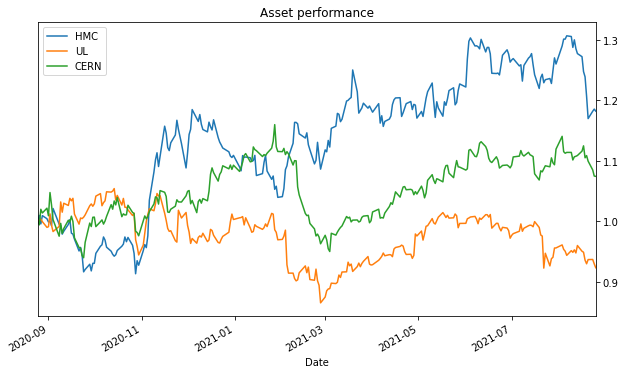

In [56]:
select = hist[look].dropna()
ax = (select/select.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()